# Bootstrap sampling

In [1]:
import xarray as xr
import numpy as np
import sys
import random
from scipy import stats
import glob
from resampling import _resample_iterations_idx
from definitions import * # imports all functions from definitions.py

xr.set_options(keep_attrs = True, display_style = 'html')  # Attributes of DataArrays will be kept through operations.

alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/PW_GW_analysis/'
dir_path = '/home/hochatmstud/bene/'

In [2]:
def g_kde(y, x):
    """Firstly, kernel density estimation of the probability density function of randomized anomalies.
    Secondly, evaluates the estimated pdf on a set of points.
    
    Args:
        y (np.array): datapoints to estimate from (randomized anomalies)
        x (np.array): datapoints to be evaluated (composite values)
    Returns:
        np.array: the estimated pdf on composite values
    """
    print(y)
    mask = np.isnan(y)
    kde = stats.gaussian_kde(y[~mask])
    return kde(x)

In [3]:
station = 'Leipzig'

In [4]:
# Parameters
station = "Leipzig"


## Wind measurements

In [5]:
ds_wind = read_group('wind',station)

u = read_var(ds_wind,'u0')
v = read_var(ds_wind,'v0')

u_anomalie = anomalie('dayofyear',u)

v_anomalie = anomalie('dayofyear',v)

sea_u = sea(40,station,u)
sea_u_anomalie = sea(40,station,u_anomalie)

sea_v = sea(40,station,v)
sea_v_anomalie = sea(40,station,v_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
#var = sys.argv[1] # ta, ua ; input variable
time_scale = sys.argv[2] # 20 or 30 ; input timescale
its = 10000 # 10000 ; number of samples
#what = sys.argv[4] # anomalies ; what kind of anomalies
#DJF_bool = sys.argv[5] # DJF only (bool)
rechunk = True # allows rechunking in xr.apply_ufunc

if station == 'Leipzig':
    size = 7
elif station == 'Esrange':
    size = 11
elif station == 'Sodankyla':
    size = 4
elif station == 'Sodankyla_Kiruna':
    size = 11
elif station == 'CMOR':
    size = 9
elif station == 'RioGrande':
    size = 4
elif station == 'Davis':
    size = 7

line_width = 5

In [7]:
#u_anomalie
u_anomalie['name'] = 'statistical significance'

### for-loop via the lags

In [8]:
u_anomalie = u_anomalie.sel(alt=slice(80,100)).dropna('time')

In [9]:
sea_u_anomalie = sea_u_anomalie.sel(alt=slice(80,100)).dropna('days')

In [10]:
p = []

for lag in range(-40,41,1):
    #print(comp_name, size)
    # samples generation (loaded from external function)
    rnd_arr = _resample_iterations_idx(u_anomalie, 
                                    its, 'time', replace=True, chunk=False, dim_max = size) 
    #print(rnd_arr)
    print("".ljust(line_width)+'{} samples generated'.format(its))
    ## load of composite dataarray
    #comp_file = f'{root_path}composites_woSSW{w_clim}/{var}_{what}_comp_{comp_name}_{time_scale}days.nc'
    #ds_comp = xr.open_dataarray(comp_file)*factor
    #print("".ljust(line_width)+'{} opened'.format(comp_file))
    
    # statistical significance calculation (vectorized g_kde)
    da_kde = xr.apply_ufunc(g_kde, rnd_arr, sea_u_anomalie.sel(days=lag),\
                       input_core_dims=[['iteration'], []],\
                       vectorize=True, dask='parallelized',\
                       exclude_dims=set(("iteration",)),  \
                       output_core_dims=[[]], \
                       output_dtypes=[sea_u_anomalie['u0_mean'].dtype])
    print("".ljust(line_width)+'p-values calculated')
    # output the calculation                        
    #outfile_name = f'{dir_path}bootstrap_test_{station}_lag_{lag}.nc'
    da_kde['name'] = u_anomalie['name']
    #da_kde.to_netcdf(outfile_name)
    #print("".ljust(line_width)+'{} saved'.format(outfile_name))
    #del da_kde, rnd_arr, ds_comp
    #print()
    #da_kde.plot.scatter(y='alt', x='u0_mean')
    #da_kde.plot.scatter(y='alt', x='u0_std')
    p.append(da_kde) 

     10000 samples generated
[ 1.32983333 -1.85239796  0.91014626 ...  0.99163605 -0.99429592
  1.34704762]
[ 1.32855782  0.12602381  1.79586054 ...  0.40840816 -0.07156803
  2.3495034 ]
[1.00364966 1.3387551  2.22472789 ... 0.0079966  1.5910102  2.74718027]
[ 0.37734354  2.3175      2.82686395 ... -0.28062585  2.34940476
  3.0752415 ]
[-0.55683333  3.28264966  3.62457823 ... -0.24983673  2.42706803
  3.31688776]
[-0.47132993  3.77281293  4.28111565 ... -0.08503061  2.31904422
  3.07138435]
[-0.75418707  3.49309184  4.978      ...  0.32716667  2.85810884
  2.57622449]
[-0.8984898   3.17315306  4.91151361 ...  0.44237075  3.07985714
  1.95621429]
[-1.26361224  2.82019388  4.42934694 ...  0.2932517   2.73540136
  1.59542177]
[-1.78013265  1.92837415  3.01672449 ...  0.42657823  2.06907823
  1.07747279]
[0.40248639 4.37617177 3.76215306 ... 2.3643145  1.74285714 2.31517687]
[ 1.32983333 -1.85239796  0.91014626 ...  0.99163605 -0.99429592
  1.34704762]
[ 1.32855782  0.12602381  1.79586054 

[ 5.33803061  4.33971429  4.4702449  ... -2.08888435  5.68219048
 -4.52090136]
[ 3.83382653  3.96747619  4.48755782 ... -1.01998639  4.9100034
 -2.5872517 ]
[ 2.37010204  3.04578912  4.43108503 ...  0.41477551  4.42293197
 -0.34730952]
[0.84483673 2.00509864 5.12822109 ... 0.79678571 4.26989796 2.56359524]
[-0.49039796  1.32554762  4.42238435 ...  0.84793197  5.07854082
  4.89165986]
[-1.66893197  1.12083673  2.9744932  ...  0.95410544  5.09228571
  5.22834014]
[-2.81506803  1.35451701  1.76407143 ...  0.9472517   4.04306122
  4.95368367]
[-3.84321088  1.46292517  1.33792177 ...  0.39868707  2.30154422
  4.11569048]
[-3.96785374  0.59307143  0.74664966 ... -0.18401701  1.1490034
  3.44734354]
[-2.97833333 -0.38472449 -0.13648299 ... -0.22848299  0.16753401
  3.06411224]
[-3.43798392 -0.04267643 -0.51151206 ...  2.27500085  1.41028401
  8.04960513]
     p-values calculated
     10000 samples generated
[-0.66502041 -0.48137415  6.69820068 ... -0.0247381   1.25513605
 -4.82098639]
[-2.126

[ 1.70762245 -2.44262245  0.47581973 ...  6.7412551  -3.68971429
  3.5160068 ]
[ 1.86434014 -2.74588435 -0.25016327 ...  5.56428912 -4.25061905
  3.1430068 ]
[ 2.475      -2.76783673 -0.44721088 ...  4.28671769 -5.40990476
  3.02353741]
[ 3.32821305 -1.58939796  1.43873754 ...  5.05395578 -6.96933333
  3.49262755]
     p-values calculated
     10000 samples generated
[-2.49281633 -2.79067347  1.07517347 ... -2.26766327 -3.94753401
 -2.80627211]
[-2.4802449  -2.45858503  1.83538095 ... -3.62963605 -2.91861224
 -1.83840476]
[-2.62280952 -2.15482993  3.57597279 ... -3.90360204 -2.73076871
 -1.14248299]
[-2.47888435 -1.63729592  3.90452381 ... -3.65895238 -2.55313946
  0.02594898]
[-2.07308163 -1.47153741  3.39360204 ... -2.5782415  -2.82271769
  1.32937755]
[-1.25905102 -1.56540136  2.2627415  ... -1.12272789 -2.8909966
  2.55219048]
[-0.59070748 -1.8207449   1.18013265 ... -0.63253741 -3.08738095
  2.96181633]
[-0.26343537 -1.71127891  0.12026871 ... -0.36746939 -3.06562585
  3.03781633]

     10000 samples generated
[-0.15810204 -0.65210204 -2.72209184 ...  1.78147619 -3.37790476
  2.17779932]
[ 1.07867347 -1.64461905 -2.09557143 ...  0.3082381  -2.03771429
 -0.29123129]
[ 2.36935374 -1.54019728 -0.68542517 ... -0.98890476 -1.4712381
 -1.72722109]
[ 3.06079252 -0.47718707  0.93256463 ... -1.66757143 -0.31395238
 -3.05609184]
[ 2.23463265  1.02817007  2.00832993 ... -2.61257143  0.33180952
 -4.3075    ]
[ 1.52676531  2.5952449   3.03942857 ... -2.49147619  1.25038095
 -5.66765986]
[ 1.1112585   3.8759898   4.26080612 ... -2.30019048  2.153
 -7.10108503]
[ 0.87596259  4.57934014  5.36213265 ... -2.01328571  2.6237619
 -7.99711224]
[ 0.02258844  4.78306803  5.89506463 ... -1.69985714  3.12861905
 -7.80263946]
[-0.78003401  4.8482415   6.2632517  ... -1.58485714  3.32442857
 -7.11638435]
[-2.52399267  9.06959524  9.40337479 ... -1.82771429  4.26407143
 -5.09757326]
[-0.15810204 -0.65210204 -2.72209184 ...  1.78147619 -3.37790476
  2.17779932]
[ 1.07867347 -1.64461905 -2.09

[-4.71234014 -0.78142177 -3.1497619  ... -2.6199898  -6.86865306
  0.80588776]
[-5.25931293 -0.24096599 -3.47407823 ... -2.77177551 -6.432
  0.65910884]
[-5.18880612 -0.39690476 -3.40784014 ... -2.68281973 -6.00404422
  1.15781973]
[-2.61469983 -2.28681122 -5.23830952 ... -0.82197279 -6.93082313
  3.67178051]
[-5.16222449  1.79446939  2.38731633 ... -6.36969728 -5.29032313
  1.43451361]
[-5.11564286 -0.38336054  1.02614626 ... -6.54292857 -6.03479932
  1.50360544]
[-4.42354422 -0.85282993  0.10855442 ... -6.03080612 -6.74796599
  1.31030952]
[-3.89418027 -1.34071429 -0.75982313 ... -4.64844898 -6.86788776
  1.07137075]
[-4.00488435 -1.99348639 -1.51258503 ... -3.98215646 -6.87144898
  0.8924898 ]
[-3.73016667 -2.36260204 -2.1377585  ... -3.45819388 -6.63879592
  0.93807483]
[-3.99262925 -1.65504082 -2.68832993 ... -2.86745918 -6.74953741
  0.89420068]
[-4.71234014 -0.78142177 -3.1497619  ... -2.6199898  -6.86865306
  0.80588776]
[-5.25931293 -0.24096599 -3.47407823 ... -2.77177551 -6.4

[-9.18714286  1.63885374  5.1207483  ...  2.86896939  4.68964626
 -2.41392177]
[-8.64163946  1.32010544  5.45169048 ...  1.61396939  3.28744218
 -1.65066667]
[-8.04170068  0.87328571  4.77617347 ... -0.1094898   1.54270408
 -1.54501701]
[-7.22290476  1.04684354  3.35933673 ... -1.59042857 -0.76476531
 -1.32897619]
[-5.99081293  1.16642517  1.89343197 ... -2.79504422 -2.56156463
 -1.24415306]
[-4.37638776  1.08843537  0.91144898 ... -3.24969728 -3.44044218
 -0.08321429]
[-3.58639116  4.6814966   2.31649629 ... -5.81557143 -3.44358163
 -0.14419649]
     p-values calculated
     10000 samples generated
[ 2.89465306  1.67713946 -1.43051701 ...  1.93783673 -3.87445578
 -3.05661565]
[ 3.15428912  1.53468027 -0.75357823 ...  3.02097279 -4.30203741
 -2.07244558]
[ 2.41611224  1.18903061  0.17570748 ...  3.34870748 -4.79834694
 -1.05157143]
[ 1.61371769  0.6439932   2.05770068 ...  3.80458163 -5.89273469
 -0.89091837]
[ 0.33485034 -0.13111905  3.6789932  ...  4.44852041 -6.23838435
 -1.7957551 

[-1.45081293 -9.5487619  -2.43496259 ... -4.30343878 -4.63171429
  3.89558844]
[-1.40008844 -8.38035714 -3.00165986 ... -3.86723129 -6.51842857
  4.18386395]
[-2.05178231 -6.70841156 -3.7202585  ... -3.09243878 -7.12885714
  3.86357823]
[-3.32522789 -5.35644558 -3.70777551 ... -1.68382993 -7.23342857
  3.40767687]
[-4.26356803 -3.69063605 -3.66916327 ... -0.1962415  -7.32571429
  3.09311905]
[-4.7509966  -1.67402381 -2.83229592 ...  1.09045238 -6.90485714
  2.44320068]
[-4.73921088  0.63252041 -1.71457483 ...  1.97160544 -7.32585714
  1.21446599]
[-5.71762585  4.14540816 -0.94805495 ...  3.68507653 -5.80803741
 -2.10444401]
     p-values calculated
     10000 samples generated
[-10.75772109  -9.25794558  -3.00747959 ...  -4.60669388  -0.21009524
  -5.85285714]
[-8.62027211 -6.97123129 -1.37465986 ... -1.9357483  -1.64017347
 -4.23108163]
[-6.98080952 -5.11754082 -0.09973469 ...  0.80208503 -2.64072789
 -2.98365306]
[-4.43670408 -3.13256463  0.38794558 ...  2.8672449  -3.20209864
 -1.31

[-0.62482653 -0.80201701  1.44467687 ...  0.22935374  0.61471769
 -1.7219898 ]
[-1.4852619  -1.28380952  1.34462585 ...  0.57887075  1.20760544
  0.11430272]
[-2.59560884 -0.88409184  1.02644218 ...  0.2747415   1.81666667
  0.95033333]
[-3.50414286 -0.00741156  0.30886735 ...  0.02611905  2.13163946
  1.89082313]
[-4.07228231  0.54280952 -0.16412245 ...  0.03334694  1.44316667
  3.17487755]
[-3.64914966e+00  9.55568027e-01  3.30612245e-03 ... -5.83673469e-02
  3.45826531e-01  3.58685714e+00]
[-2.81977551  1.50568367 -0.31132993 ...  1.07856463 -0.0040102
  3.73221088]
[-1.24069048  0.10923129 -2.64360544 ...  2.67193197 -0.12661224
  3.89682313]
[ 0.77807182  2.50417687 -3.74258684 ...  2.28215221  2.00341575
  4.00712059]
     p-values calculated
     10000 samples generated
[ 2.02203401 -0.52684014 -1.68636735 ... -1.04521088  0.62771429
 -2.89985714]
[ 1.0922381   0.49813265 -1.97177211 ... -1.1540068   0.84252381
 -3.83809524]
[ 0.06636395  0.93408503 -2.11817347 ... -1.29319048  

[ 6.5545102   3.1722551   1.88942857 ... -1.10637415  1.6182381
  2.00667007]
[ 6.79944218  2.94727891  1.8262381  ... -1.25083673  0.95333333
  1.12682653]
[ 5.80652041  2.99387075  2.09680952 ... -1.57032993  0.72247619
 -0.36479932]
[ 4.27458163  3.09744898  2.18642857 ... -1.65388095  0.53319048
 -1.54497959]
[ 3.15681633  3.30536395  2.50919048 ... -2.0612381   0.51
 -2.6100068 ]
[ 1.85962585  3.30488435  3.30619048 ... -2.68136395  0.58214286
 -3.18329932]
[ 0.70678912  2.58529592  3.69042857 ... -3.58364966  0.34928571
 -2.92878571]
[-0.23987879  1.22507352  4.15437229 ... -0.3222483   1.04961905
 -0.11272567]
     p-values calculated
     10000 samples generated
[ 1.78823469  3.56191156  7.33152041 ...  1.62520748 -0.84693878
  3.78279932]
[ 1.6677381   2.78690476  6.88210204 ...  1.91186735 -0.83805102
  4.69376871]
[ 2.34644558  2.40481973  6.02179252 ...  1.7112551  -0.89873129
  5.04088776]
[ 2.70844218  1.57053741  4.63653741 ...  1.16523129 -1.19531633
  4.28261905]
[ 2.5

[-3.20313605 -1.79110204  3.4792381  ... -0.50855102  2.69781293
  4.89204762]
[-3.10542517 -2.63319048  3.18039116 ... -1.70010884  3.87223469
  3.95507483]
[-3.5920068  -3.25840136  2.48695578 ... -1.90696259  5.11636735
  3.1609898 ]
[-4.15486735 -3.23019728  1.70042177 ... -1.72095918  6.1882449
  2.5600102 ]
[-4.20456463 -3.09170408  1.0789898  ... -1.94245918  6.73168707
  1.82872789]
[-2.39594558 -3.56839534  0.111823   ...  1.44312059  4.5242203
  0.71295949]
     p-values calculated
     10000 samples generated
[-0.5502449   9.31921088  2.44836054 ...  4.15835374 -1.18878571
 -0.99970748]
[-1.29144558  6.91769388  2.25903741 ...  3.43772789 -1.65340816
 -0.77447279]
[-2.44311565  4.3079932   1.77557143 ...  2.31296599 -0.88652721
 -0.4037619 ]
[-3.95114286  1.55798639  2.21351701 ...  0.93613946 -0.44407483
 -0.39128231]
[-4.89288095 -0.76802721  2.5987449  ... -0.02006803 -0.81070408
 -0.43967007]
[-5.7327483  -2.31643878  3.14659524 ... -1.2450034  -1.88832313
 -0.05759184]


[-1.8145068   1.04905782 -1.36435714 ...  2.89840345 -5.37370068
 -5.55042857]
[-1.49179592  1.07629932 -0.75488435 ...  1.70454343 -5.06888095
 -4.17485714]
[-1.51080272  0.92827211 -0.34245578 ...  0.26389848 -4.28942857
 -2.84461905]
[-1.28230612  0.55241156  0.38345238 ... -0.89229016 -3.83712245
 -1.62095238]
[-1.46044061  1.30593537  1.55438928 ... -3.25402891 -3.60336054
 -0.64305102]
     p-values calculated
     10000 samples generated
[ 3.80788095 14.1137381   4.6469898  ... -2.30702041 -3.55017687
  4.69715646]
[ 4.21527551 11.13636735  3.48731293 ... -3.14529252 -1.47316667
  4.46143537]
[ 4.96584694  8.17905782  2.46222109 ... -4.27108503  0.24509524
  3.84280612]
[ 5.12742177  5.13612245  1.29957823 ... -5.5209932   2.18106803
  3.19088095]
[ 4.21883333  2.44669048  1.07910204 ... -5.59313946  3.72564286
  3.36647959]
[ 2.58462925  1.15198299  0.43242177 ... -5.04072789  4.46165646
  3.60629592]
[ 1.17778231  0.13156463 -0.40868367 ... -3.45708503  4.82278571
  3.56211224

[ 3.68622279  2.77357993 -2.99146448 ... -0.0586131   4.4734618
 -0.71044573]
     p-values calculated
     10000 samples generated
[ 7.93846939e-01  2.32661565e+00 -6.29658425e+00 ... -2.61909524e+00
 -2.74829932e-03 -4.85430612e+00]
[ 2.93280272  0.81746939 -6.67929356 ... -3.54842517 -0.1552381
 -3.12140136]
[ 4.49528912 -1.22052041 -6.12060937 ... -3.79378912 -0.2545102
 -2.30452381]
[ 5.13137415 -3.05164626 -5.45559498 ... -4.44902381 -0.10771088
 -1.64319728]
[ 5.02145918 -4.26260204 -3.76212376 ... -5.11411565  0.60419048
 -1.34323129]
[ 4.93682313 -4.7239966  -1.61732025 ... -5.76302381  1.4499966
 -0.66054422]
[ 4.17552381 -4.68732993 -0.12126321 ... -6.25107143  1.95378571
 -0.16668707]
[ 3.46627891 -5.06087755  1.12002983 ... -6.31829252  2.21112245
 -0.54179592]
[ 2.94045578 -5.38451361  2.26586107 ... -6.22063605  2.68959524
 -1.7422619 ]
[ 2.50820068 -6.11327891  3.68752276 ... -5.71280612  3.95156803
 -3.05309184]
[ 3.12155233 -5.70557535  8.72965659 ... -2.65433516  6.5

     10000 samples generated
[ 1.70624228  1.21519728  2.97233673 ... -0.05087415  0.07070068
  5.75978912]
[ 0.81027106  0.63438095  1.88138776 ...  1.0219932  -0.77157483
  4.2147381 ]
[ 0.45946546  0.27056122  0.59392177 ...  1.9865     -1.34508163
  2.96382313]
[ 0.36853428 -0.16760204 -0.67568367 ...  2.57705102 -1.97419728
  1.10801361]
[ 0.2020191  -0.46790136 -1.4435     ...  2.65859524 -2.61729592
 -1.14246599]
[-0.72152773 -0.74089116 -2.10519388 ...  1.7369898  -3.10381293
 -2.91346939]
[-1.52854212 -0.79261565 -2.52842517 ...  1.23181633 -2.95943878
 -4.59768027]
[-2.21967766 -0.23393878 -2.79145918 ...  0.48039116 -2.71236735
 -6.26107823]
[-3.12385662  1.05711905 -2.87386395 ... -0.10742517 -2.31009864
 -7.8290102 ]
[-3.95607248  2.5850068  -2.69934354 ... -0.31389116 -1.39987075
 -9.43678231]
[-5.01526832  3.90475    -1.77861967 ... -1.21802276  4.01941994
 -9.89488961]
[ 1.70624228  1.21519728  2.97233673 ... -0.05087415  0.07070068
  5.75978912]
[ 0.81027106  0.6343809

[ 7.81056463  0.70405102  3.34693197 ...  2.84466667  2.34767713
 -1.28331293]
[ 5.34462925  0.97287075  1.42441497 ...  1.78232313  1.09984903
 -2.34736054]
[ 3.17716667  0.26982313 -0.41786395 ...  0.58315306  0.40848247
 -3.45503741]
[ 1.67620408 -0.39102381 -0.92778912 ... -0.22508163 -0.46662036
 -3.76046599]
[ 0.41361905 -1.0705068  -1.21966327 ... -1.26394558 -1.36895997
 -3.4162551 ]
[-1.25922789 -1.896      -1.39921769 ... -1.75703401 -1.71814574
 -3.09067687]
[-2.82116667 -2.60784014 -2.71796599 ... -2.06542177 -1.8913752
 -2.94177551]
[-5.25158503 -2.10909615 -5.21709382 ... -3.2612237   2.79871808
  0.82943223]
[9.92341837 1.84346599 6.75547619 ... 3.26617007 8.96434432 2.8695068 ]
[9.67716667 1.54579252 6.34836735 ... 3.32221429 6.41410099 1.55529592]
[ 8.93835374  1.02259524  5.17790476 ...  3.45456463  3.99587703
 -0.03353741]
[ 7.81056463  0.70405102  3.34693197 ...  2.84466667  2.34767713
 -1.28331293]
[ 5.34462925  0.97287075  1.42441497 ...  1.78232313  1.09984903
 -

[-1.39819048  3.90012245 -7.05194218 ... -2.15604082  0.16788435
 -4.04385714]
[ -3.52291497   4.33279932 -10.52833844 ...  -1.26411982   0.27194419
  -4.96066558]
[-1.42014286  3.45434694 11.19603061 ... -3.93417687 -5.36465646
 -3.24231633]
[-3.06428571  3.34341837  9.6652415  ... -4.61933673 -5.42278571
 -2.72684694]
[-4.93904762  2.29837755  7.5365     ... -4.76984014 -5.07721769
 -1.56462245]
[-6.1892381   1.74218027  5.39434694 ... -4.96265986 -4.54762585
 -1.25667007]
[-6.56942857  1.92755442  3.22446939 ... -4.8447619  -4.02677891
 -2.05088095]
[-6.15633333  2.30222449  1.29938435 ... -4.24334354 -3.05334014
 -2.98603401]
[-5.41771429  2.32277211 -0.58516327 ... -3.59920408 -1.91215306
 -3.94607143]
[-4.13590476  2.30552381 -2.4552619  ... -2.89835714 -0.75066327
 -4.60887755]
[-2.98442857e+00  3.23867347e+00 -4.85607483e+00 ... -2.49791837e+00
 -2.73809524e-03 -4.47962925e+00]
[-1.39819048  3.90012245 -7.05194218 ... -2.15604082  0.16788435
 -4.04385714]
[ -3.52291497   4.3327

[ 4.55931973 -0.67406463  2.97415306 ... -2.71461905 -2.72142857
  3.97192857]
[ 6.37357143 -0.71937755  3.21037075 ... -2.49037415 -2.26166667
  5.04373129]
[ 7.53168707 -1.18114286  3.23726531 ... -2.44607823 -1.37285714
  5.3822585 ]
[ 7.63942517 -1.26541156  2.86627211 ... -2.59470408 -0.9662381
  4.6182483 ]
[ 7.26491837 -0.72394898  2.7140068  ... -2.24969728 -0.5762381
  3.55216327]
[ 6.4817415   0.32284354  2.20181973 ... -1.32832313 -0.04142857
  2.45321088]
[ 5.91526531  1.75952381  1.55386735 ... -0.77980612  0.993
  2.37710884]
[ 6.49215306  2.1028175  -1.31583163 ... -0.43549892  1.72708318
  3.65923849]
     p-values calculated
     10000 samples generated
[3.65469728 4.87952041 2.89864966 ... 6.78073129 2.86255442 3.41788435]
[ 4.32172109  6.25323129  2.68977211 ...  6.17558844 -0.1729898
  2.67871769]
[ 5.12430272  7.50484354  1.90219048 ...  5.3552517  -2.50692177
  1.48896259]
[ 4.85618707  8.29641156  1.4017415  ...  4.62912245 -3.90529932
 -0.16057823]
[ 3.7729932  

In [11]:
p_comp =  xr.concat(p, dim = 'days')
p_comp['days'] = range(-40, 40+1)
p_comp = p_comp.where(p_comp['u0_mean'] < 0.05, other = -0.05)

In [12]:
#p_comp

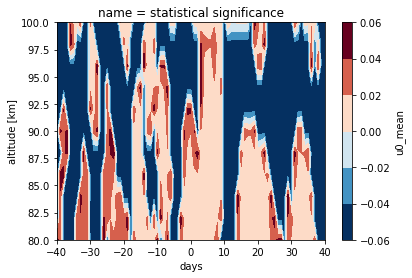

In [13]:
p_comp['u0_mean'].plot.contourf(x='days')